# Analyse pixelated potential reconstructions

__last update__: 30/08/22

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
from tqdm import tqdm
import numpy as np
import pickle as pkl
import corner
import copy
import tqdm
from scipy import ndimage
from scipy.optimize import minimize
import seaborn as sns
import jax
import jax.numpy as jnp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import LogNorm, TwoSlopeNorm, Normalize
from matplotlib.gridspec import GridSpec
plt.rc('image', interpolation='none')
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.LensModel.Profiles.multipole import Multipole
from herculens.Parameters.covariance import FisherCovariance
from herculens.Util import grf_util, param_util, plot_util

In [2]:
SAVE_FIGURES = False
figure_dir = os.path.join('figures', 'analyses')

In [3]:
def add_scale_bar(ax, extent, pixel_size, size_arcsec=1, bar_width_pixel=1, 
                  position=None, color='white', fontsize=16):
    if position is None:
        position = (extent[0]+5*pixel_size, extent[2]+5*pixel_size)
    width, height = size_arcsec, bar_width_pixel*pixel_size
    bar = mpatches.Rectangle(position, width, height, facecolor=color)
    ax.add_patch(bar)
    text_offset_y = 2 * height
    text = '{}"'.format(size_arcsec)
    ax.text(position[0]+width/2., position[1]+text_offset_y, text, color=color, fontsize=fontsize, 
            horizontalalignment='center', verticalalignment='bottom')

def get_model_data(scenario='real', perturbation_type='dark_halo', regul_str='fiducial', 
                   pixel_scale=4, return_hmc_results=False, nsamples=400, suffix=''): 
    
    filename = f'-{scenario}-{perturbation_type}-scale_{pixel_scale}-smooth_source'
    if scenario == 'real':
        filename += '-init_from_smooth'
    filename += suffix
    
    with open(os.path.join('results',  f'{regul_str}_regul_strength', 'sumplot' + filename + '.pkl'), 'rb') as f:
        _, full_lens_image, full_kwargs_result, input_kwargs_result, \
            mask_fitgrid, pixpot_noise_map, \
            pixpot_truth_highres, pixpot_truth_fitgrid, \
            _, cov_matrix_pixpot, _, _, _, _ \
            = pkl.load(f)
        
    if return_hmc_results:
        with open(os.path.join('results', f'{regul_str}_regul_strength', f'samples_HMC_n{nsamples}' + filename + '.pkl'), 'rb') as f:
            hmc_data = pkl.load(f)
            samples_hmc, logL_history, extra_fields, _ = hmc_data[3]
        
    pixpot_model = full_kwargs_result['kwargs_lens'][-1]['pixels']
    try:  # TODO: fix that
        pixpot_model_error = np.sqrt(np.abs(cov_matrix_pixpot)).reshape(*pixpot_model.shape)
    except ValueError as e:
        print("Reshaping error map assuming 5 smooth lens and 7 smooth source parameters!")
        pixpot_model_error = np.sqrt(np.abs(cov_matrix_pixpot[5:-7])).reshape(*pixpot_model.shape)

    lensed_src = full_lens_image.model(**full_kwargs_result, lens_light_add=False)
    src_snr = lensed_src / np.sqrt(full_lens_image.Noise.C_D_model(lensed_src))
    mask_highres = (src_snr > 5).astype(float)
    
    grid_class = full_lens_image.Grid
    
    model_data = (
        pixpot_model, pixpot_truth_highres, pixpot_truth_fitgrid, mask_highres, mask_fitgrid, 
        pixpot_model_error, grid_class, full_lens_image, full_kwargs_result
    )
    
    if return_hmc_results:
        return model_data, (samples_hmc, logL_history, extra_fields)
    else:
        return model_data

def get_model_data_analytical(scenario='real', perturbation_type='dark_halo', 
                              regul_str='fiducial', pixel_scale=4, mcmc_bool=False):
    
    filename = f'sumplot-{scenario}-{perturbation_type}-scale_{pixel_scale}-smooth_source'
    if mcmc_bool is True:
        filename += '-MCMC'
    filename += '.pkl'
    with open(os.path.join('results', f'{regul_str}_regul_strength', filename), 'rb') as f:
        _, full_lens_image, full_kwargs_result, input_kwargs_result, \
            mask_fitgrid, pixpot_noise_map, \
            pixpot_truth_highres, pixpot_truth_fitgrid, \
            _, _, cov_matrix, _, mean_values, _ \
            = pkl.load(f)
        
    grid_class = full_lens_image.Grid
        
    return mean_values, cov_matrix


def get_sensitivity_data(scenario='real', perturbation_type='dark_halo', grid_scale=4, mcmc_bool=False):
    filename = f'sensimap-scale_{grid_scale}-{scenario}-{perturbation_type}-smooth_potential-smooth_source.pkl'
    with open(os.path.join('results', filename), 'rb') as f:
        content = pkl.load(f)
        data, full_lens_image, full_kwargs_result, \
            halo_lens_image, halo_param,\
            sensitivity_map, x_minima, y_minima, z_minima,\
            = content
    return sensitivity_map, x_minima, y_minima, z_minima

In [4]:
def extract_pixpot_from_hmc(samples, logprob, skip_num_start=None, skip_num_end=None):
    if skip_num_start is None:
        skip_num_start = 0
    if skip_num_end is None:
        skip_num_start = samples.shape[1]+1
    num_pix = int(np.sqrt(samples.shape[1] - skip_num_start - skip_num_end))
    pixpot_med  = np.median(samples[:, skip_num_start:-skip_num_end], axis=0).reshape(num_pix, num_pix)
    pixpot_mean = np.mean(samples[:, skip_num_start:-skip_num_end], axis=0).reshape(num_pix, num_pix)
    pixpot_std  = np.std(samples[:, skip_num_start:-skip_num_end], axis=0).reshape(num_pix, num_pix)
    idx_maxprob = int(np.argmax(logprob))
    pixpot_maxprob = samples[idx_maxprob, skip_num_start:-skip_num_end].reshape(num_pix, num_pix)
    return pixpot_med, pixpot_mean, pixpot_std, pixpot_maxprob

## Lens LS: subhalo mass & position

In [5]:
regul_str_LS = 'fiducial'
model_LS, hmc_LS = get_model_data(scenario='real', 
                                  perturbation_type='dark_halo', regul_str=regul_str_LS,
                                  pixel_scale=3, return_hmc_results=True, nsamples=1600)
model_map, mask_fit, model_error = model_LS[0], model_LS[4], model_LS[5]
x_grid_fit, y_grid_fit = model_LS[6].model_pixel_coordinates('lens')
extent = model_LS[6].extent
lens_image, kwargs_results = model_LS[7], model_LS[8]

num_lens, num_src = 5, 7
samples_hmc_raw, loss_history_hmc_raw, extra_fields_hmc = hmc_LS

model_LS_refine = get_model_data_analytical(scenario='real', 
                          perturbation_type='refined-dark_halo', 
                          pixel_scale=3, mcmc_bool=True)
mean_values, cov_matrix = model_LS_refine
print(mean_values.shape, cov_matrix.shape)

sensitivity_map, x_minima, y_minima, z_minima = get_sensitivity_data(perturbation_type='dark_halo', grid_scale=1)

(15,) (15, 15)


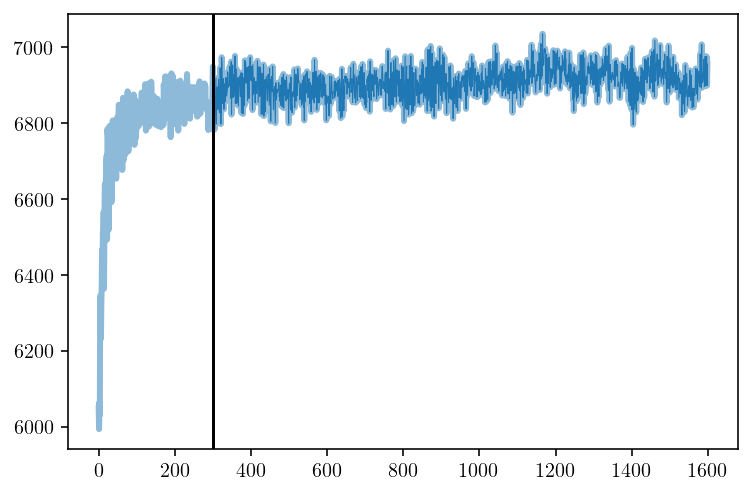

In [6]:
num_burnin = 300
samples_hmc = np.copy(samples_hmc_raw[num_burnin:, :])
loss_history_hmc = np.copy(loss_history_hmc_raw[num_burnin:])
cov_matrix_hmc = np.cov(samples_hmc.T)

plt.plot(range(len(samples_hmc_raw)), loss_history_hmc_raw, linewidth=3, alpha=0.5, color='tab:blue')
plt.plot(range(num_burnin, len(samples_hmc_raw)), loss_history_hmc, linewidth=0.5, alpha=1, color='tab:blue')
plt.axvline(num_burnin, color='k')
plt.show()

### Constraints on the mass and position from analytical model

In [7]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM

Om0 = 0.3
H0 = 70.0
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Ob0=0.0)

z_lens, z_source = 0.3, 0.7
lens_cosmo = LensCosmo(z_lens, z_source, cosmo=cosmo)

In [8]:
kwargs_macro_lens_input = {'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}
kwargs_ext_shear_input = {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0., 'dec_0': 0.}
kwargs_subhalo_input = {'theta_E': 0.07, 'center_x': 1.9, 'center_y': -0.4}

log_M_truth = np.log10(lens_cosmo.mass_in_theta_E(kwargs_subhalo_input['theta_E']))
cx_truth, cy_truth = kwargs_subhalo_input['center_x'], kwargs_subhalo_input['center_y']

print(log_M_truth)

9.023675582920061


In [9]:
idx_theta_E_sub = 5
idx_cx_sub, idx_cy_sub = 6, 7

theta_E_sub = mean_values[idx_theta_E_sub]
theta_E_sub_err = np.sqrt(cov_matrix[idx_theta_E_sub, idx_theta_E_sub])
print(f"Subhalo theta_E: {theta_E_sub:.4f} +/- {theta_E_sub_err:.4f}")

M_sub = lens_cosmo.mass_in_theta_E(theta_E_sub)
M_sub_err = 2 * theta_E_sub * lens_cosmo.mass_in_theta_E(theta_E_sub_err)  # error propagation
print(f"Subhalo mass: {M_sub:.2e} +/- {M_sub_err:.2e}")

log_M_sub = np.log10(M_sub)
log_M_sub_err = 1./np.log(10) * M_sub_err / M_sub  # error propagation

cx_sub, cx_sub_err = mean_values[idx_cx_sub], np.sqrt(cov_matrix[idx_cx_sub, idx_cx_sub])
cy_sub, cy_sub_err = mean_values[idx_cy_sub], np.sqrt(cov_matrix[idx_cy_sub, idx_cy_sub])

print(f"Subhalo log(mass): {log_M_sub:.2f} +/- {log_M_sub_err:.8f}")
print(f"Subhalo position: {cx_sub:.3f} +/- {cx_sub_err:.3f}, {cy_sub:.3f} +/- {cy_sub_err:.3f}")

Subhalo theta_E: 0.0687 +/- 0.0008
Subhalo mass: 1.02e+09 +/- 1.68e+04
Subhalo log(mass): 9.01 +/- 0.00000719
Subhalo position: 1.899 +/- 0.008, -0.408 +/- 0.005


In [10]:
# we also build a covariance matrix for only the SIS subhalo parameters (for later)
cov_matrix_sis = np.array([
    [cov_matrix[idx_theta_E_sub, idx_theta_E_sub], cov_matrix[idx_theta_E_sub, idx_cx_sub], cov_matrix[idx_theta_E_sub, idx_cy_sub]],
    [cov_matrix[idx_cx_sub, idx_theta_E_sub], cov_matrix[idx_cx_sub, idx_cx_sub], cov_matrix[idx_cx_sub, idx_cy_sub]],
    [cov_matrix[idx_cy_sub, idx_theta_E_sub], cov_matrix[idx_cy_sub, idx_cx_sub], cov_matrix[idx_cy_sub, idx_cy_sub]],
])

print(cov_matrix_sis)

[[ 5.68260795e-07  1.39427729e-06 -2.06633083e-07]
 [ 1.39427729e-06  7.18030577e-05  1.50615798e-05]
 [-2.06633083e-07  1.50615798e-05  2.79808179e-05]]


### Constraints from the pixelated reconstruction

#### Detect minimum in potential space

Subhalo position (error = 1/2 pixel): 1.94 +/- 0.12, -0.48 +/- 0.12


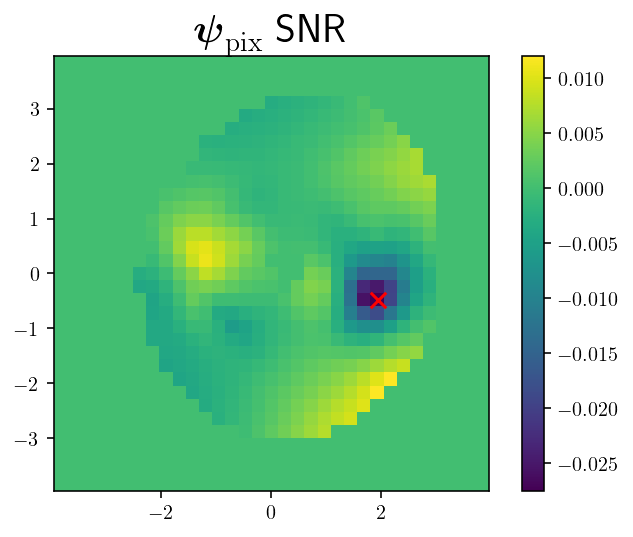

In [11]:
# detect minimum
model_masked = np.copy(model_map)
model_masked[mask_fit == 0] = 1e10
min_index_2d = np.where(model_masked == model_masked.min())
min_x_coord, min_y_coord = float(x_grid_fit[min_index_2d][0]), float(y_grid_fit[min_index_2d][0])
model_pix_size = abs(float(x_grid_fit[0, 0] - x_grid_fit[0, 1]))
print(f"Subhalo position (error = 1/2 pixel): {min_x_coord:.2f} +/- {model_pix_size/2:.2f}, {min_y_coord:.2f} +/- {model_pix_size/2:.2f}")

plt.title(r"$\boldsymbol{\psi}_{\rm pix}$ SNR", fontsize=20)
plt.imshow(model_map * mask_fit, extent=extent, origin='lower')
plt.colorbar()
plt.scatter(min_x_coord, min_y_coord, s=60, c='r', marker='x')
plt.show()

In [12]:
print(samples_hmc.shape)
model_hmc_med, model_hmc_mean, model_hmc_std, _ = extract_pixpot_from_hmc(samples_hmc, loss_history_hmc,
                                                                          skip_num_start=num_lens, 
                                                                          skip_num_end=num_src)

(1300, 1101)


number of pixels with SNR > 3: 15
number of pixels with SNR > 5: 6


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.
/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: No contour levels were found within the data range.


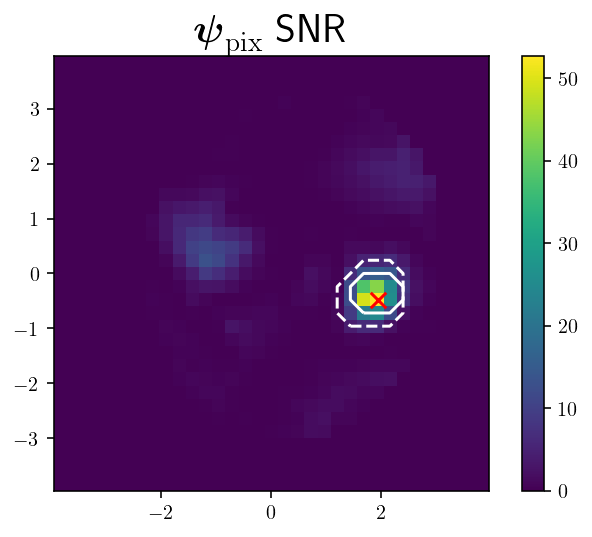

In [13]:
model_snr = np.abs(model_hmc_mean) / model_hmc_std
model_snr2 = model_snr**2

mask_snr3_hmc = (model_snr > 3).astype(float)
mask_snr3_hmc[:, :15] = 0.  # remove the bit of mask far from the subhalo position
mask_snr5_hmc = (model_snr > 5).astype(float)
print(f"number of pixels with SNR > 3:", int(np.sum(mask_snr3_hmc)))
print(f"number of pixels with SNR > 5:", int(np.sum(mask_snr5_hmc)))

# choose the mask to use for the remaining of the analysis
#mask_snr_hmc = mask_snr3_hmc


plt.title(r"$\boldsymbol{\psi}_{\rm pix}$ SNR", fontsize=20)
plt.imshow(model_snr2 * mask_fit, extent=extent, origin='lower')
plt.colorbar()
plt.contour(mask_snr5_hmc, extent=extent, origin='lower', levels=[0], colors='white')
plt.contour(mask_snr3_hmc, extent=extent, origin='lower', levels=[0], colors='white', linestyles='--')
plt.scatter(min_x_coord, min_y_coord, s=60, c='r', marker='x')
plt.show()

/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.
/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: No contour levels were found within the data range.


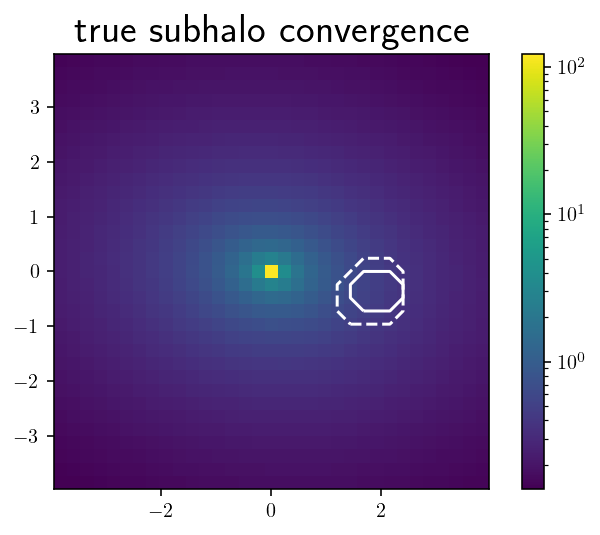

In [14]:
# true input perturbing convergence evaluated on the model grid
from herculens.LensModel.lens_model import LensModel
lens_model_sis = LensModel(['SIS'])
model_kappa_map_input_subhalo = np.array(lens_model_sis.kappa(x_grid_fit, y_grid_fit, [kwargs_subhalo_input]))
lens_model_macro = LensModel(['SIE', 'SHEAR'])
model_kappa_map_input_macro = np.array(lens_model_macro.kappa(x_grid_fit, y_grid_fit, 
                                                              [kwargs_macro_lens_input, 
                                                               kwargs_ext_shear_input]))
kwargs_macro_lens_input_shift = copy.deepcopy(kwargs_macro_lens_input)
kwargs_macro_lens_input_shift['center_x'] = kwargs_results['kwargs_lens'][0]['center_x']
kwargs_macro_lens_input_shift['center_y'] = kwargs_results['kwargs_lens'][0]['center_y']
model_kappa_map_input_macro_shift = np.array(lens_model_macro.kappa(x_grid_fit, y_grid_fit, 
                                                              [kwargs_macro_lens_input_shift, 
                                                               kwargs_ext_shear_input]))
kwargs_macro_lens_input_shift = copy.deepcopy(kwargs_macro_lens_input)
kwargs_macro_lens_input_shift['center_x'] = kwargs_results['kwargs_lens'][0]['center_x']
kwargs_macro_lens_input_shift['center_y'] = kwargs_results['kwargs_lens'][0]['center_y']
model_kappa_map_input_macro_shift = np.array(lens_model_macro.kappa(x_grid_fit, y_grid_fit, 
                                                              [kwargs_macro_lens_input_shift, 
                                                               kwargs_ext_shear_input]))

plt.title(r"true subhalo convergence", fontsize=20)
#plt.imshow(model_kappa_map_input_subhalo, origin='lower', extent=extent, cmap='viridis')
plt.imshow(model_kappa_map_input_macro_shift, origin='lower', extent=extent, cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.contour(mask_snr5_hmc, extent=extent, origin='lower', levels=[0], colors='white')
plt.contour(mask_snr3_hmc, extent=extent, origin='lower', levels=[0], colors='white', linestyles='--')
plt.show()

-0.19839317 0.4269532


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]


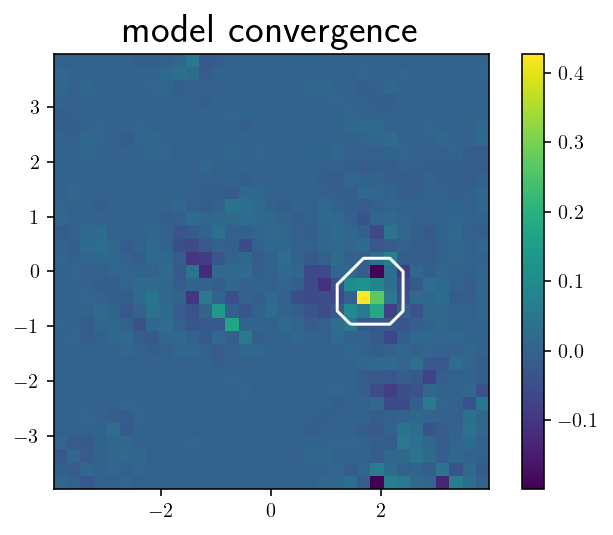

In [15]:
# get the best-fit model the pixelated convergence
model_kappa_map = np.array(lens_image.LensModel.kappa(x_grid_fit, y_grid_fit, kwargs_results['kwargs_lens'], k=2))
print(model_kappa_map.min(), model_kappa_map.max())

# best-fit smooth component of the convergence
model_kappa_smooth = np.array(lens_image.LensModel.kappa(x_grid_fit, y_grid_fit, kwargs_results['kwargs_lens'], k=[0, 1]))

model_mask_pos = (model_kappa_map > 0).astype(float)

plt.title(r"model convergence", fontsize=20)
plt.imshow(model_kappa_map, extent=extent, origin='lower', cmap='viridis') #, vmin=0)
plt.colorbar()
plt.contour(mask_snr3_hmc, extent=extent, origin='lower', levels=[0], colors='white')
plt.show()

#### Bootstrap from covariance matrices

In [16]:
@jax.jit
def get_kappa_pixelated(pot_pixels):
    return lens_image.LensModel.kappa(x_grid_fit, y_grid_fit, [{}, {}, {'pixels': pot_pixels}], k=2)

kappa_hmc_realizations = []
num_samples = samples_hmc.shape[0]
for n in tqdm.tqdm(range(num_samples), total=num_samples, desc="bootstrap"):
    # get pixelated model for each HMC sample 
    pot_pixels = samples_hmc[n, num_lens:-num_src].reshape(*model_map.shape)
    kappa_real = get_kappa_pixelated(pot_pixels)
    kappa_hmc_realizations.append(kappa_real)

kappa_hmc_realizations = np.array(kappa_hmc_realizations)

bootstrap: 100%|██████████| 1300/1300 [00:01<00:00, 1151.04it/s]


In [17]:
@jax.jit
def get_kappa_analytical(p):
    return lens_model_sis.kappa(x_grid_fit, y_grid_fit, [{'theta_E': p[0], 'center_x': p[1], 'center_y': p[2]}])

# bootstrap analytical model
# TODO: replace by HMC samples
kappa_ana_realizations = []
num_samples = 10000
for n in tqdm.tqdm(range(num_samples), total=num_samples, desc="bootstrap"):
    params = np.random.multivariate_normal([theta_E_sub, cx_sub, cy_sub], cov_matrix_sis)
    kappa_ana_real = get_kappa_analytical(params)
    kappa_ana_realizations.append(kappa_ana_real)
kappa_ana_realizations = np.array(kappa_ana_realizations)

bootstrap: 100%|██████████| 10000/10000 [00:01<00:00, 6073.24it/s]


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys


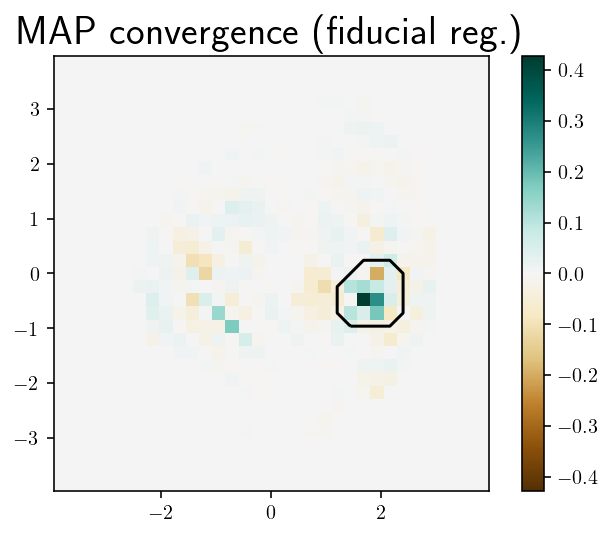

In [20]:
plt.figure()
plt.title(f"MAP convergence ({regul_str_LS} reg.)", fontsize=20)
vmax = np.max(model_kappa_map[mask_fit==1])
#plt.imshow(np.mean(kappa_hmc_realizations, axis=0) * mask_fit, origin='lower', extent=extent, cmap='BrBG', norm=TwoSlopeNorm(0))
plt.imshow(model_kappa_map * mask_fit, origin='lower', extent=extent, cmap='BrBG', norm=Normalize(-vmax, vmax)) # norm=TwoSlopeNorm(0))
plt.colorbar()
plt.contour(mask_snr3_hmc, extent=extent, origin='lower', levels=[0], colors='black')
plt.show()

In [21]:
def get_mass_from_convergence(kappa_map, mask=None):
    if mask is None:
        mask = np.ones_like(kappa_map)
    # sum convergence pixel values
    sum_kappa = np.sum(kappa_map * mask)
    # convert units to solar masses
    model_mass = sum_kappa * lens_cosmo.sigma_crit_angle * lens_image.Grid.pixel_area
    return np.log10(model_mass)

log_model_mass = get_mass_from_convergence(model_kappa_map, mask_snr3_hmc)
log_model_mass_snr5 = get_mass_from_convergence(model_kappa_map, mask_snr5_hmc)
print(f"Subhalo mass inside region (pix. model): {log_model_mass:.2f}")

log_input_kappa_mass = get_mass_from_convergence(model_kappa_map_input_subhalo, mask_snr3_hmc)
log_input_kappa_mass_snr5 = get_mass_from_convergence(model_kappa_map_input_subhalo, mask_snr5_hmc)
print(f"Subhalo mass inside region (input): {log_input_kappa_mass:.2f}")

Subhalo mass inside region (pix. model): 8.71
Subhalo mass inside region (input): 8.91


In [22]:
log_model_mass_samples_hmc = []
log_model_mass_samples_hmc_snr5 = []
log_model_mass_samples_ana = []
log_model_mass_samples_ana_snr5 = []
for n in range(kappa_hmc_realizations.shape[0]):
    log_model_mass_samples_hmc.append(get_mass_from_convergence(kappa_hmc_realizations[n], mask_snr3_hmc))
    log_model_mass_samples_hmc_snr5.append(get_mass_from_convergence(kappa_hmc_realizations[n], mask_snr5_hmc))
for n in range(kappa_ana_realizations.shape[0]):
    log_model_mass_samples_ana.append(get_mass_from_convergence(kappa_ana_realizations[n], mask_snr3_hmc))
    log_model_mass_samples_ana_snr5.append(get_mass_from_convergence(kappa_ana_realizations[n], mask_snr5_hmc))
log_model_mass_samples_hmc = np.array(log_model_mass_samples_hmc)
log_model_mass_samples_hmc_snr5 = np.array(log_model_mass_samples_hmc_snr5)
log_model_mass_samples_ana = np.array(log_model_mass_samples_ana)
log_model_mass_samples_ana_snr5 = np.array(log_model_mass_samples_ana_snr5)

In [23]:
def statistics_from_samples(samples):
    median = np.median(samples)
    err_inf = median - np.percentile(samples, 16)
    err_sup = np.percentile(samples, 84) - median
    print(f"> statistics: {median:.4f} {err_inf:.4f} + {err_sup:.4f}")
    return median, err_inf, err_sup

In [24]:
print(f"Mass samples from summing all kappa pixels ({len(log_model_mass_samples_hmc)} samples):")
log_M_median, log_M_err_inf, log_M_err_sup = statistics_from_samples(log_model_mass_samples_hmc)

Mass samples from summing all kappa pixels (1300 samples):
> statistics: 8.7062 0.0554 + 0.0490


In [25]:
print(f"Mass samples from analytical model ({len(log_model_mass_samples_ana)} samples):")
log_M_ana_median, log_M_ana_err_inf, log_M_ana_err_sup = statistics_from_samples(log_model_mass_samples_ana)

Mass samples from analytical model (10000 samples):
> statistics: 8.9034 0.0067 + 0.0070


In [26]:
print(f"Mass samples from HMC samples ({len(log_model_mass_samples_hmc)} samples):")
log_M_hmc_median, log_M_hmc_err_inf, log_M_hmc_err_sup = statistics_from_samples(log_model_mass_samples_hmc)

Mass samples from HMC samples (1300 samples):
> statistics: 8.7062 0.0554 + 0.0490


In [27]:
model_total_mass_subhalo = get_mass_from_convergence(np.abs(model_kappa_map[model_kappa_map < 0]))
#model_total_mass_subhalo = get_mass_from_convergence(np.abs(model_kappa_map[model_kappa_map < 0]))
print(f"Total lens log(mass) (subhalo model) = {model_total_mass_subhalo:.3f}")
model_total_mass = get_mass_from_convergence(model_kappa_map + model_kappa_smooth)
print(f"Total lens log(mass) (model) = {model_total_mass:.3f}")
model_total_mass_input = get_mass_from_convergence(model_kappa_map_input_subhalo + model_kappa_map_input_macro_shift)
print(f"Total lens log(mass) (input) = {model_total_mass_input:.3f}")

Total lens log(mass) (subhalo model) = 9.434
Total lens log(mass) (model) = 11.341
Total lens log(mass) (input) = 11.347


### Plots

/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: No contour levels were found within the data range.
/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: No contour levels were found within the data range.


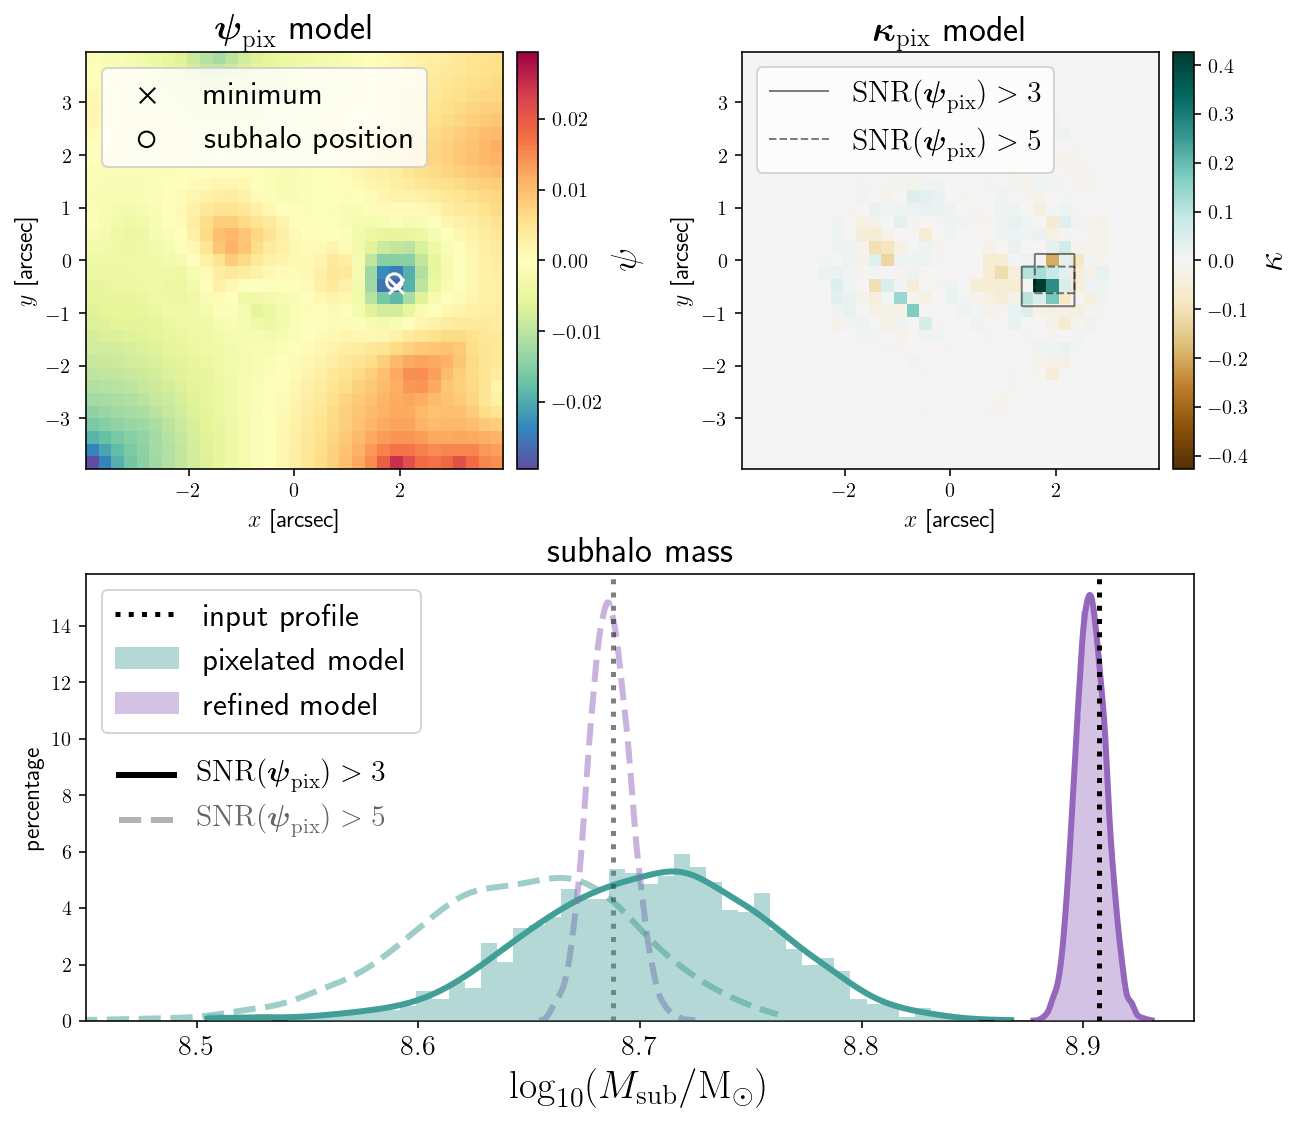

In [70]:
mask, mask_fit = model_LS[3], model_LS[4]
pot_mask_nans = np.nan * np.zeros_like(mask_fit)
pot_mask_nans[mask_fit == 0] = 1

pix_scl = lens_image.Grid.pixel_width

# create high-resolution for SNR masks for better contours
mask_snr3_hmc_hr = ndimage.zoom(mask_snr3_hmc, 30, order=0, mode='nearest')
mask_snr5_hmc_hr = ndimage.zoom(mask_snr5_hmc, 30, order=0, mode='nearest')

fontsize = 18
gs = GridSpec(2, 2)
fig = plt.figure(figsize=(9, 8))


ax = plt.subplot(gs[0, 0])
ax.set_title(r"$\boldsymbol{\psi}_{\rm pix}$ model", fontsize=fontsize)
ax.set_xlabel(r"$x$ [arcsec]", fontsize=fontsize-6)
ax.set_ylabel(r"$y$ [arcsec]", fontsize=fontsize-6)
model_map_offset = model_map  # - model_map[mask_fit == 1].min()
vmax = np.abs(model_map_offset).max()
im = ax.imshow(model_map_offset, origin='lower', extent=extent, cmap='Spectral_r', norm=Normalize(-vmax, vmax))
#vmax = np.abs(model_map_offset[mask_fit==1]).max()
#im = ax.imshow(model_map_offset * mask_fit, origin='lower', extent=extent, cmap='Spectral_r', norm=Normalize(-vmax, vmax))
im.set_rasterized(True)
ax.scatter(min_x_coord, min_y_coord, c='black', s=60, marker='x', linewidth=1, 
           label=r"minimum")
ax.scatter(cx_truth, cy_truth, s=60, marker='o', linewidth=1, facecolors='none', edgecolors='black',
           label=r"subhalo position")
plot_util.nice_colorbar(im, label=r"$\psi$", fontsize=fontsize)
ax.legend(loc='upper left', fontsize=fontsize-2)
ax.scatter(min_x_coord, min_y_coord, c='white', s=60, marker='x', linewidth=1.5, 
           label=r"minimum")
ax.scatter(cx_truth, cy_truth, s=60, marker='o', linewidth=1.5, facecolors='none', edgecolors='white',
           label=r"subhalo position")


ax = plt.subplot(gs[0, 1])
ax.set_xlabel(r"$x$ [arcsec]", fontsize=fontsize-6)
ax.set_ylabel(r"$y$ [arcsec]", fontsize=fontsize-6)
ax.set_title(r"$\boldsymbol{\kappa}_{\rm pix}$ model", fontsize=fontsize)
#vmax = np.abs(model_kappa_map).max()
#im = ax.imshow(model_kappa_map, origin='lower', extent=extent, cmap='BrBG', norm=Normalize(-vmax, vmax))
vmax = np.abs(model_kappa_map[mask_fit == 1]).max()
im = ax.imshow(model_kappa_map * mask_fit, origin='lower', extent=extent, cmap='BrBG', norm=Normalize(-vmax, vmax))
im.set_rasterized(True)
plot_util.nice_colorbar(im, label=r"$\kappa$", fontsize=fontsize)
cs = ax.contour(mask_snr3_hmc_hr, extent=extent, levels=[1], linewidths=1.,
                colors='black', linestyles='-', alpha=0.5)
cs.collections[0].set_label(r"${\rm SNR}(\boldsymbol{\psi}_{\rm pix}) > 3$")
cs = ax.contour(mask_snr5_hmc_hr, extent=extent, levels=[1], linewidths=1., 
                colors='black', linestyles='--', alpha=0.5)
cs.collections[0].set_label(r"${\rm SNR}(\boldsymbol{\psi}_{\rm pix}) > 5$")
ax.legend(fontsize=fontsize-3, loc='upper left')


alpha_snr5 = 0.5
ax = plt.subplot(gs[1, :])
ax.set_title("subhalo mass", fontsize=fontsize)
hist_color1 = matplotlib.cm.get_cmap('BrBG')(200)
hist_color2 = 'tab:purple'
stat_mode, ylabel = 'percent', "percentage"
ax.axvline(log_input_kappa_mass, linestyle=':', linewidth=2.5, color='black', alpha=1,
           label=r"input profile", zorder=5)
ax.axvline(log_input_kappa_mass_snr5, linestyle=':', linewidth=2.5, color='black', alpha=alpha_snr5,
           zorder=3)
sns.histplot(log_model_mass_samples_hmc, ax=ax, color=hist_color1, alpha=0.4,
             kde=True, stat=stat_mode, bins=50,
             linewidth=0, line_kws={'linewidth': 3}, label=r"pixelated model", zorder=5)
sns.histplot(log_model_mass_samples_hmc_snr5, ax=ax, color=hist_color1, alpha=0,
             kde=True, stat=stat_mode, bins=50,
             linewidth=0, line_kws={'linewidth': 3, 'linestyle': '--', 'alpha': alpha_snr5}, zorder=4)
#ax.axvline(log_M_hmc_median, linestyle=':', linewidth=2, color=hist_color1)
#ax.axvline(log_M_hmc_median-log_M_hmc_err_inf, linestyle=':', linewidth=1.5, color=hist_color1)
#ax.axvline(log_M_hmc_median+log_M_hmc_err_sup, linestyle=':', linewidth=1.5, color=hist_color1)
sns.histplot(log_model_mass_samples_ana, ax=ax, color=hist_color2, alpha=0.4,
             kde=True, stat=stat_mode, bins=20,
             linewidth=0, line_kws={'linewidth': 3}, label=r"refined model", zorder=5)
sns.histplot(log_model_mass_samples_ana_snr5, ax=ax, color=hist_color2, alpha=0,
             kde=True, stat=stat_mode, bins=20,
             linewidth=0, line_kws={'linewidth': 3, 'linestyle': '--', 'alpha': alpha_snr5}, zorder=4)
ax.set_xlabel(r"$\log_{10}(M_{\rm sub} / {\rm M}_{\odot})$", fontsize=fontsize+2)
ax.set_ylabel(ylabel, fontsize=fontsize-6)
ax.set_xlim(8.45, 8.95)
ax.tick_params(axis='x', which='major', labelsize=fontsize-4)
ax.legend(fontsize=fontsize-2, loc='upper left', ncol=1)

from matplotlib.lines import Line2D
#ax.text(0.05, 0.55, "region:", color='black', fontsize=fontsize-2, transform=ax.transAxes)
ax.text(0.1, 0.55, r"${\rm SNR}(\boldsymbol{\psi}_{\rm pix}) > 3$", ha='left', va='center',
        color='black', fontsize=fontsize-3, transform=ax.transAxes)
line_snr3 = Line2D([0.03, 0.08], [0.55, 0.55], linewidth=3, linestyle='-', 
                   color='black', transform=ax.transAxes)
ax.add_line(line_snr3)
ax.text(0.1, 0.45, r"${\rm SNR}(\boldsymbol{\psi}_{\rm pix}) > 5$", ha='left', va='center', alpha=alpha_snr5+0.1, 
        color='black', fontsize=fontsize-3, transform=ax.transAxes)
line_snr5 = Line2D([0.03, 0.08], [0.45, 0.45], linewidth=3, linestyle='--', alpha=alpha_snr5-0.2, 
                   color='black', transform=ax.transAxes)
ax.add_line(line_snr5)

# annotations
#ax.annotate("", xy=(8.76, 3.8), xytext=(8.8, 7.8), arrowprops={'arrowstyle': '->'})
#ax.annotate("", xy=(8.89, 3.8), xytext=(8.8, 7.8), arrowprops={'arrowstyle': '->'})
#ax.annotate(r"${\rm SNR}(\boldsymbol{\psi}_{\rm pix}) > 3$", fontsize=14,
#            xy=(8.8, 8.), xytext=(8.8, 8.), va='bottom', ha='center')
#ax.annotate("", xy=(8.62, 4.4), xytext=(8.61, 7.8), arrowprops={'arrowstyle': '->', 'alpha': alpha_snr5})
#ax.annotate("", xy=(8.67, 6.5), xytext=(8.61, 7.8), arrowprops={'arrowstyle': '->', 'alpha': alpha_snr5})
#ax.annotate(r"${\rm SNR}(\boldsymbol{\psi}_{\rm pix}) > 5$", fontsize=14, alpha=alpha_snr5,
#            xy=(8.8, 8.), xytext=(8.61, 7.8), va='bottom', ha='right')

fig.tight_layout()
fig.subplots_adjust(hspace=0.2, wspace=0.45)
plt.show()

In [71]:
if SAVE_FIGURES:
    figure_name = 'subhalo_position_mass_v2.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight', dpi=300)

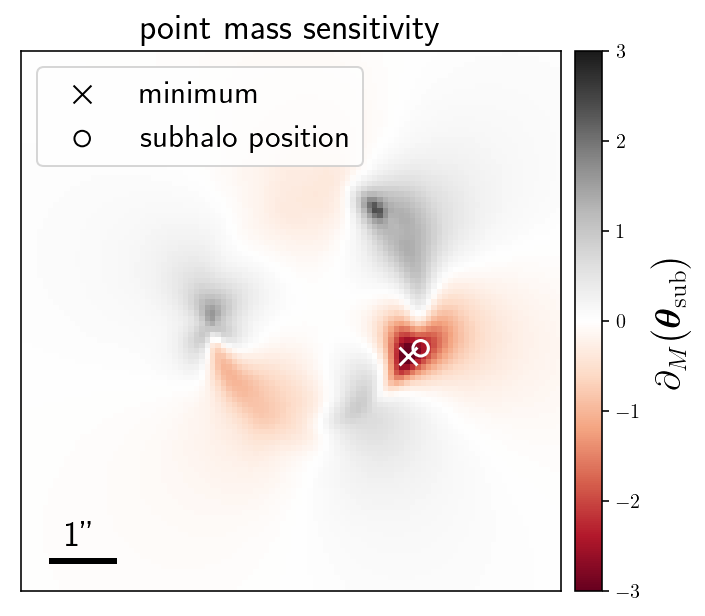

In [20]:
fontsize = 18

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("point mass sensitivity", fontsize=fontsize)
vmax = 3 # np.abs(sensitivity_map).max()
norm_sensit = Normalize(-vmax, vmax)
cmap_sensit = 'RdGy'
im = ax.imshow(sensitivity_map, extent=extent, origin='lower', norm=norm_sensit, cmap=cmap_sensit)
im.set_rasterized(True)
add_scale_bar(ax, extent, pix_scl, size_arcsec=1, bar_width_pixel=1, 
              color='black', fontsize=fontsize) 
#ax.contour(mask, levels=[1], extent=extent, origin='lower', colors='black', linewidths=2, alpha=0.3)
#kwargs_scatter = dict(marker='o', s=np.abs(z_minima)*4e1, 
#                      edgecolors='white', facecolors='none',
#                      linewidths=1, alpha=1)
#ax.scatter(x_minima, y_minima, zorder=10, **kwargs_scatter)
min_x_sensit = x_minima[z_minima == z_minima.min()]
min_y_sensit = y_minima[z_minima == z_minima.min()]
ax.scatter(min_x_sensit, min_y_sensit, c='black', s=80, marker='x', linewidth=1, 
           label=r"minimum")
ax.scatter(min_x_sensit, min_y_sensit, c='white', s=80, marker='x', linewidth=1.5)
ax.scatter(cx_truth, cy_truth, s=60, marker='o', linewidth=1, facecolors='none', edgecolors='black',
           label=r"subhalo position")
ax.scatter(cx_truth, cy_truth, s=60, marker='o', linewidth=1.5, facecolors='none', edgecolors='white')
ax.legend(fontsize=fontsize-2, loc='upper left') #, bbox_to_anchor=(-0.05, 0.5), loc='center right', ncol=1)
plot_util.nice_colorbar(im, label=r"$\partial_M\big( \boldsymbol \theta_{\rm sub} \big)$", fontsize=fontsize)
#plot_util.nice_colorbar_residuals(im, sensitivity_map, norm_sensit.vmin, norm_sensit.vmax,
#                                  label=r"$\partial_M\big( \boldsymbol \theta_{\rm sub} \big)$", 
#                                  fontsize=fontsize)


fig.tight_layout()
#fig.subplots_adjust(wspace=0.3)
plt.show()

In [21]:
if SAVE_FIGURES:
    figure_name = 'subhalo_sensitivity.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight', dpi=300)

## Lens PS: power spectrum analysis

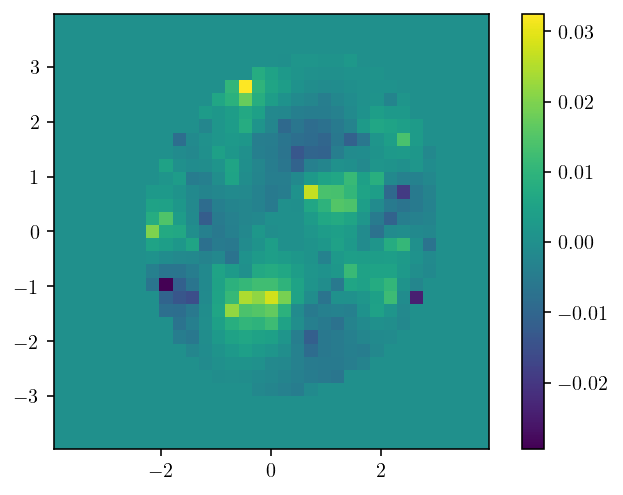

In [7]:
model_PS_ideal = get_model_data(scenario='ideal', 
                          perturbation_type='GRF', 
                          pixel_scale=3)
model_ideal = model_PS_ideal[0]
model_error_ideal = model_PS_ideal[5]

model_PS, hmc_PS = get_model_data(scenario='real', 
                          perturbation_type='GRF', 
                          pixel_scale=3, return_hmc_results=True, suffix='-no_BL_wavelets')
model = model_PS[0]
input_highres = model_PS[1]
input_fit = model_PS[2]
mask_highres = model_PS[3]
mask_fit = model_PS[4]
model_error = model_PS[5]
grid = model_PS[6]
pix_scl = grid.pixel_width
extent = grid.extent
x_grid, y_grid = grid.pixel_coordinates
x_grid_fit, y_grid_fit = grid.model_pixel_coordinates('lens')

num_lens, num_src = 5, 7
samples_hmc, loss_history_hmc, extra_fields_hmc = hmc_PS
cov_matrix_hmc = np.cov(samples_hmc.T)


model_PS_scale2 = get_model_data(scenario='ideal', 
                          perturbation_type='GRF', 
                          pixel_scale=2)
model_scale2 = model_PS_scale2[0]
mask_fit_scale2 = model_PS_scale2[4]
model_error_scale2 = model_PS_scale2[5]
grid_scale2 = model_PS_scale2[6]
x_grid_fit_scale2, y_grid_fit_scale2 = grid_scale2.model_pixel_coordinates('lens')


plt.imshow(model * mask_fit, origin='lower', extent=extent, norm=TwoSlopeNorm(0))
#plt.imshow(model_error, origin='lower', extent=extent, norm=LogNorm())
plt.colorbar()
plt.show()

In [8]:
def azimuthal_average(xx, yy, image, mask_image=None):
    if mask_image is None:
        mask_image = np.ones_like(image)
        
    # setup the radial bins
    x = xx[0, :]
    npix = len(x)
    r = x[npix//2:]
    r_step = r[1] - r[0]
    r_bin_centers = r[:-1] + r_step/2.
    
    # function that computes the mean inside an annulus
    rr = np.hypot(xx, yy)
    image_m = image * mask_image
    mean_in_annulus = lambda R: image_m[(rr >= R-r_step/2.) & (rr < R+r_step/2.)].mean()
    
    # evaluate it over a range of radii
    radii = r_bin_centers[1:]  # ignore the very central annulus because of there is drop in power (numerics?)
    average = np.vectorize(mean_in_annulus)(radii)
    return radii, average

def power_spectrum(xx, yy, image, mask_image=None):
    """
    Computes the azimuthally averaged power spectrum of an image.
    """
    if mask_image is None:
        mask_image = np.ones_like(image)
    
    # get number of pixels and pixel size 
    npix_x, npix_y = xx.shape
    pix_size = np.abs(xx[0, 0] - xx[0, 1])  # assumes square pixels
        
    # squared magnitude of FFT
    image_norm = image * pix_size**2
    fft_abs2 = np.abs(np.fft.fft2(image_norm * mask_image))**2
    
    # shift FFT image so that small wave numbers are at the center
    fft_abs2 = np.fft.fftshift(fft_abs2)
    
    # get radial bins
    k_x = np.fft.fftshift(np.fft.fftfreq(npix_x, pix_size))
    k_y = np.fft.fftshift(np.fft.fftfreq(npix_y, pix_size))
    k_xx, k_yy = np.meshgrid(k_x, k_y)
    
    # azimuthal average
    radii, ps_average = azimuthal_average(k_xx, k_yy, fft_abs2)
    
    return radii, ps_average

#print(power_spectrum(x_grid_fit, y_grid_fit, maps_test[0]))
#print(power_spectrum(x_grid, y_grid, maps_test[2]))

#plt.figure()
#plt.imshow(power_spectrum(arrays[0][1])[1], origin='lower')
#plt.show()

In [9]:
def ps_linear_fit(k, ps, image, mask_image=None, idx_start_k=0):
    x = np.log10(k[idx_start_k:])
    y = np.log10(ps[idx_start_k:])
    p, cov = np.polyfit(x, y, deg=1, cov=True)
    slope, intercept = float(p[0]), float(p[1])
    slope_err = np.sqrt(np.abs(float(cov[0, 0])))
    intercept_err = np.sqrt(np.abs(float(cov[1, 1])))
    
    k_long = np.logspace(-1, 1, 10)  # for large line on the plot
    fit = 10**intercept * k_long**slope
    
    # normalization such that when feeding the input image we get back correct variance
    var_truth = 1.00e-03
    var_input_image = 1.765e-04
    norm_grf = var_input_image / var_truth
    
    #norm_grf_input = 2025.7998437138235
    #norm_grf = norm_grf_input
    #print(norm_grf)
    
    #norm_grf = grf_util.grf_normalization(npix, npix, npix*pix_scl, npix*pix_scl, slope)
    #print(norm_grf)
    #
    #npix_fit = image.shape[0]
    #pix_scl_fit = pix_scl if image.shape[0] == npix else pix_scl * potential_pixel_scale
    #norm_grf = grf_util.grf_normalization(npix_fit, npix_fit, npix_fit*pix_scl_fit, npix_fit*pix_scl_fit, slope)
    #print(norm_grf)
    #
    #k_x = np.fft.fftshift(np.fft.fftfreq(npix, pix_scl))
    #k_y = np.fft.fftshift(np.fft.fftfreq(npix, pix_scl))
    #k_xx, k_yy = np.meshgrid(k_x, k_y)
    #Psum = np.sum((mask*np.hypot(k_xx, k_yy))**slope)
    #norm_grf = (npix**2.)/(2.*Psum)
    #print(norm_grf)
    
    var_grf = 10**intercept / norm_grf
    var_grf_err = np.log(10) * var_grf * (intercept_err/norm_grf)  # error propagation
    beta_grf = - slope
    beta_grf_err = slope_err
    
    return k_long, fit, (var_grf, var_grf_err), (beta_grf, beta_grf_err)

In [10]:
def fit_values(var_tuple, beta_tuple):
    logvar, beta = np.log10(var_tuple[0]), beta_tuple[0]
    logvar_err = 1./(var_tuple[0]*np.log(10)) * var_tuple[1]  # error propagation
    beta_err = beta_tuple[1]
    return beta, beta_err, logvar, logvar_err

def fit_text_latex(var_tuple, beta_tuple):
    beta, beta_err, logvar, logvar_err = fit_values(var_tuple, beta_tuple)
    return r"$\log_{10}\sigma^2_{\rm GRF}$ = "+f"${logvar:.2f}\pm{logvar_err:.2f}$"+"\n"+r"$\beta_{\rm GRF}$ = "+f"${beta:.2f}\pm{beta_err:.2f}$"

def fit_text_print(var_tuple, beta_tuple):
    beta, beta_err, logvar, logvar_err = fit_values(var_tuple, beta_tuple)
    return f"log(sigma2) = {logvar:.2f} +/- {logvar_err:.2f} | beta = {beta:.2f} +/- {beta_err:.2f}"

def print_grf_fit_results(var_tuple, beta_tuple, name):
    #print(f"GRF params for '{name}': {fit_text_latex(var_tuple, beta_tuple)}")
    print(f"GRF params for '{name}':\n\t{fit_text_print(var_tuple, beta_tuple)}")


In [11]:
def plot_mode_power_spectrum(ax, r, ps, label, color='black', idx_start_k=0, zorder=10):
    if idx_start_k is not None and idx_start_k > 0:
        ax.scatter(r[:idx_start_k], ps[:idx_start_k], s=60, c=color, marker='x', linewidth=1, zorder=zorder)
        ax.scatter(r[idx_start_k:], ps[idx_start_k:], s=30, c=color, marker='o', linewidth=1, zorder=zorder)
        ax.plot(r[:idx_start_k+1], ps[:idx_start_k+1], alpha=0.5, 
                color=color, linestyle='-', linewidth=1.5, zorder=zorder)
        ax.plot(r[idx_start_k:], ps[idx_start_k:], label=label, 
                color=color, linestyle='-', linewidth=2, zorder=zorder)
    else:
        ax.plot(r, ps, label=label, 
                color=color, linestyle='-', linewidth=4, zorder=zorder)

GRF params for 'groundtruth':
	log(sigma2) = -3.00 +/- 0.00 | beta = 4.00 +/- 0.00
GRF params for 'input (fit grid)':
	log(sigma2) = -3.00 +/- 0.18 | beta = 3.27 +/- 0.14
GRF params for 'model':
	log(sigma2) = -3.51 +/- 0.26 | beta = 2.68 +/- 0.19
GRF params for 'model scale 2':
	log(sigma2) = -3.49 +/- 0.15 | beta = 3.26 +/- 0.09
GRF params for 'ideal':
	log(sigma2) = -3.35 +/- 0.20 | beta = 3.40 +/- 0.15
GRF params for 'input (high-res)':
	log(sigma2) = -3.11 +/- 0.17 | beta = 3.21 +/- 0.06


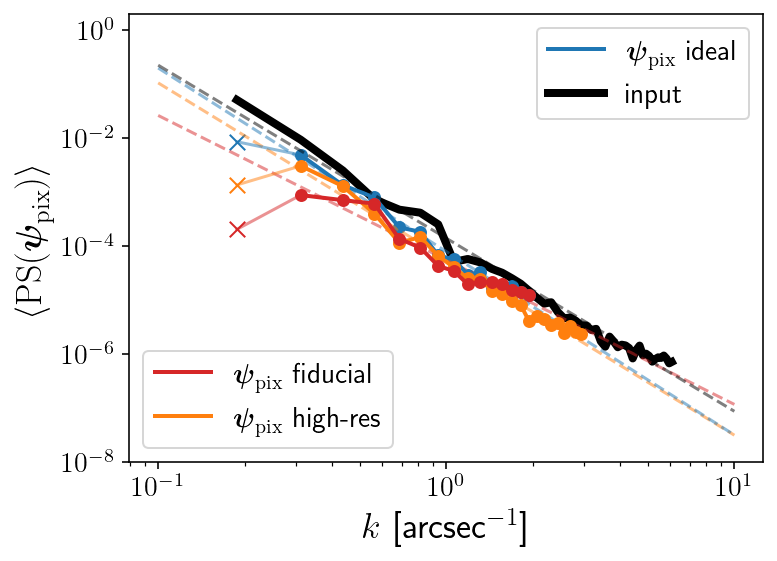

In [12]:
# ignore the n first wavenumbers for the linear fits (by index) 
idx_start_k = 1

fontsize = 18
fig, axes = plt.subplots(1, 1, figsize=(5.5, 4))
ax = axes

var_grf_truth, beta_grf_truth = (1e-3, 0), (4, 0)
print_grf_fit_results(var_grf_truth, beta_grf_truth, "groundtruth")

r, ps = power_spectrum(x_grid_fit, y_grid_fit, input_fit, mask_image=mask_fit)
x, y, var_grf_input, beta_grf_input = ps_linear_fit(r, ps, input_fit, mask_image=mask_fit, idx_start_k=idx_start_k)
print_grf_fit_results(var_grf_input, beta_grf_input, "input (fit grid)")


# power spectra for model
r, ps = power_spectrum(x_grid_fit, y_grid_fit, model, mask_image=mask_fit)
plot_mode_power_spectrum(ax, r, ps, r"$\boldsymbol{\psi}_{\rm pix}$ fiducial", color='tab:red', idx_start_k=idx_start_k, zorder=6)
x, y, var_grf_model, beta_grf_model = ps_linear_fit(r, ps, model, mask_image=mask_fit, idx_start_k=idx_start_k)
ax.plot(x, y, color='tab:red', alpha=0.5, linestyle='--', linewidth=1.5)
print_grf_fit_results(var_grf_model, beta_grf_model, "model")

# power spectra for model (scale 2)
r, ps = power_spectrum(x_grid_fit_scale2, y_grid_fit_scale2, model_scale2, mask_image=mask_fit_scale2)
plot_mode_power_spectrum(ax, r, ps, r"$\boldsymbol{\psi}_{\rm pix}$ high-res", color='tab:orange', idx_start_k=idx_start_k, zorder=4)
x, y, var_grf_model_scale2, beta_grf_model_scale2 = ps_linear_fit(r, ps, model_scale2, mask_image=mask_fit_scale2, idx_start_k=idx_start_k)
ax.plot(x, y, color='tab:orange', alpha=0.5, linestyle='--', linewidth=1.5)
print_grf_fit_results(var_grf_model_scale2, beta_grf_model_scale2, "model scale 2")

# power spectra for 'ideal' model
r, ps = power_spectrum(x_grid_fit, y_grid_fit, model_ideal, mask_image=mask_fit)
plot_mode_power_spectrum(ax, r, ps, r"$\boldsymbol{\psi}_{\rm pix}$ ideal", color='tab:blue', idx_start_k=idx_start_k, zorder=2)
x, y, var_grf_model_ideal, beta_grf_model_ideal = ps_linear_fit(r, ps, model_ideal, mask_image=mask_fit, idx_start_k=idx_start_k)
ax.plot(x, y, color='tab:blue', alpha=0.5, linestyle='--', linewidth=1.5)
print_grf_fit_results(var_grf_model_ideal, beta_grf_model_ideal, "ideal")

# power spectra for input potentials
r, ps = power_spectrum(x_grid, y_grid, input_highres, mask_image=mask_highres)
plot_mode_power_spectrum(ax, r, ps, r"input", color='black', idx_start_k=0, zorder=0)
x, y, var_grf_input_hr, beta_grf_input_hr = ps_linear_fit(r, ps, input_highres, mask_image=mask_highres, idx_start_k=0)
ax.plot(x, y, color='black', alpha=0.5, linestyle='--', linewidth=1.5)
print_grf_fit_results(var_grf_input_hr, beta_grf_input_hr, "input (high-res)")

# with error bars
#ps_err = ps_error_list[:, i]
#ps_err_up = np.zeros((2, len(ps_err)))
#ps_err_up[1, :] = ps_err  # this is for removing lower error bars (do not look good on logscale)
#ax.errorbar(r, ps, yerr=ps_err_up, label="model", zorder=100,
#            elinewidth=2, ecolor='tab:purple', 
#            color='tab:purple', linestyle='-', linewidth=4)


#ax.text(0.05, 0.05, fit_text(var_grf_model, beta_grf_model), 
#        fontsize=15, color='tab:red', 
#        ha='left', va='bottom', transform=ax.transAxes)
#ax.text(0.02, 0.22, fit_text(var_grf_model_scale2, beta_grf_model_scale2), 
#        fontsize=15, color='tab:orange', 
#        ha='left', va='bottom', transform=ax.transAxes)
#ax.text(0.95, 0.95, fit_text(var_grf_input_hr, beta_grf_input_hr), 
#        fontsize=15, color='black', 
#        ha='right', va='top', transform=ax.transAxes)
#ax.text(0.95, 0.95, fit_text(var_grf_model_ideal, beta_grf_model_ideal), 
#        fontsize=15, color='tab:blue', 
#        ha='right', va='top', transform=ax.transAxes)

ax.set_ylim(1e-8, 2e0)
ax.set_xscale('log')
ax.set_yscale('log')

ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel(r"$k$ [arcsec$^{-1}$]", fontsize=fontsize)
ax.set_ylabel(r"$\langle {\rm PS}(\boldsymbol{\psi}_{\rm pix}) \rangle$", fontsize=fontsize)
#ax.set_ylabel(r"radial $\psi_{\rm pix}$ power spectrum", fontsize=20)

#ax.legend(ax.get_legend_handles_labels()[0],
#          ax.get_legend_handles_labels()[1],
#          #bbox_to_anchor=(0.5, 1.25), loc='center', ncol=2,
#          #bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1,
#          bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=2,
#          fontsize=16)

handles, labels = ax.get_legend_handles_labels()
l1 = ax.legend(handles[:2], labels[:2], loc='lower left', fontsize=fontsize-4)
ax.legend(handles[2:], labels[2:], loc='upper right', fontsize=fontsize-4)
ax.add_artist(l1)

#fig.subplots_adjust(wspace=0.3)
fig.tight_layout()
plt.show()

In [13]:
if SAVE_FIGURES:
    figure_name = 'power_spectra_grf.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight', dpi=300)

## Lens HM: octupole fitting

(15,) (15, 15)


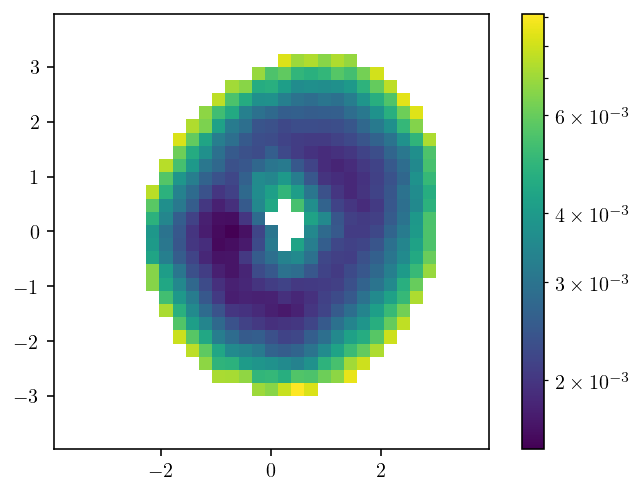

In [24]:
model_HM, hmc_HM = get_model_data(scenario='real', 
                          perturbation_type='discyness', 
                          pixel_scale=3, return_hmc_results=True)
model_map, true_map, mask, mask_fit, model_error_fim = model_HM[0], model_HM[2], model_HM[3], model_HM[4], model_HM[5]
grid = model_HM[6]
pix_scl = grid.pixel_width
extent = grid.extent
x_grid_fit, y_grid_fit = grid.model_pixel_coordinates('lens')

num_lens, num_src = 5, 7
samples_hmc, _, _ = hmc_HM
model_error_hmc = np.std(samples_hmc[50:, num_lens:-num_src], axis=0).reshape(*model_map.shape)

# choose the error map (either FIM or HMC)
model_error = model_error_hmc

model_HM_refine = get_model_data_analytical(scenario='real', 
                                            perturbation_type='refined-discyness',
                                            pixel_scale=3,
                                            mcmc_bool=True)
mean_values, cov_matrix = model_HM_refine
print(mean_values.shape, cov_matrix.shape)

#plt.imshow(model_map * mask_fit, origin='lower', extent=extent, norm=TwoSlopeNorm(0))
plt.imshow(model_error * mask_fit, origin='lower', extent=extent, norm=LogNorm())
plt.colorbar()
plt.show()

### Constraints from refined analytical model

In [25]:
# parameter index
idx_m, idx_a_m, idx_phi_m = 5, 6, 7

model_m_val = mean_values[idx_m]
model_m_err = np.sqrt(cov_matrix[idx_m, idx_m])
model_a_m_val = mean_values[idx_a_m]
model_a_m_err = np.sqrt(cov_matrix[idx_a_m, idx_a_m])
model_phi_m_val = mean_values[idx_phi_m]
model_phi_m_err = np.sqrt(cov_matrix[idx_phi_m, idx_phi_m])

print("refined octupole parameters:")
print(f"m     = {model_m_val:.2f} +/- {model_m_err:.2f}")
print(f"a_m   = {model_a_m_val:.4f} +/- {model_a_m_err:.4f}" )
print(f"phi_m = {model_phi_m_val*180./np.pi % 90:.2f} +/- {model_phi_m_err*180./np.pi % 90:.2f}" )

refined octupole parameters:
m     = 4.01 +/- 0.02
a_m   = 0.0605 +/- 0.0016
phi_m = 83.15 +/- 0.39


### Constraints from pixelated model

In [26]:
e1_lens, e2_lens = 0.15, -0.04
phi_m, _ = param_util.ellipticity2phi_q(e1_lens, e2_lens)
input_kwargs = {'a_m': 0.06, 'phi_m': float(phi_m)}
input_values = [input_kwargs['a_m'], input_kwargs['phi_m']]
print("input values:", input_kwargs)

input values: {'a_m': 0.06, 'phi_m': -0.13030119240283966}


In [27]:
multipole = Multipole()
def fit_octupole(target, error_map=None, mask=None, num_runs=300):
    if mask is None:
        mask = jnp.ones_like(target)
    if error_map is None:
        error_map = jnp.ones_like(target)
    
    @jax.jit
    def _loss(p):
        m, a_m, phi_m, offset = 4, p[0], p[1], p[2]
        model = multipole.function(x_grid_fit, y_grid_fit, m, a_m, phi_m) + offset
        return 0.5 * np.sum(mask * ((model - target) / error_map)**2)
    _grad_loss = jax.jit(jax.grad(_loss))
    
    # run multi-start gradient descent with num_runs
    loss_list, bf_list = [], []
    for n in range(num_runs):
        p0 = 1e-1 * np.random.randn(3)  # some random initial values
        #print(n, p0)
        #print("initial loss:", _loss(p0))
        #print("loss at input:", _loss(input_values))
        res = minimize(_loss, p0, method='BFGS', jac=_grad_loss)
        loss_list.append(_loss(res.x))
        bf_list.append(res.x)
        
    loss_list = np.array(loss_list)
    index = np.argmin(loss_list)  # get the absolute best fit from all the runs
    
    #plt.hist(loss_list)
    #plt.show()
    
    print("bf index", index)
    best_fit = bf_list[index]
    loss_best_fit = _loss(best_fit)
    print("loss at best-fit:", loss_best_fit)
    fim = - jax.jacfwd(jax.jacrev(_loss))(best_fit)
    cov_matrix = np.linalg.inv(fim)
    print(np.sqrt(np.abs(cov_matrix)))
    uncertainties = [
        np.sqrt(np.abs(cov_matrix[0, 0])), 
        np.sqrt(np.abs(cov_matrix[1, 1])),
        np.sqrt(np.abs(cov_matrix[2, 2]))
    ]
    return best_fit, uncertainties

In [35]:
best_fit, uncertainties = fit_octupole(model_map, error_map=model_error, mask=None)

bf index 32
loss at best-fit: 86.709305
[[1.4539744e-03 2.6754141e-04 4.2439995e-05]
 [2.6754208e-04 1.5160507e-02 1.6251074e-04]
 [4.2439995e-05 1.6251073e-04 1.2754297e-04]]


In [36]:
bf_kwargs = {'a_m': float(best_fit[0]), 'phi_m': float(best_fit[1])}
bf_uncert = {'a_m': float(uncertainties[0]), 'phi_m': float(uncertainties[1])}
print("fit results:", bf_kwargs, bf_uncert)

fit results: {'a_m': 0.023742569610476494, 'phi_m': -0.10853525996208191} {'a_m': 0.0014539744006469846, 'phi_m': 0.015160506591200829}


In [37]:
print(f"input octupole parameters: a_m = {input_kwargs['a_m']:.2f} | phi_m = {input_kwargs['phi_m']*180./np.pi+90:.2f}" )

print(f"retrieved parameters: a_m = {bf_kwargs['a_m']:.4f} +/- {bf_uncert['a_m']:.4f} | phi_m = {bf_kwargs['phi_m']*180./np.pi % 90:.4f} +/- {bf_uncert['phi_m']*180./np.pi % 90:.4f}" )
      

input octupole parameters: a_m = 0.06 | phi_m = 82.53
retrieved parameters: a_m = 0.0237 +/- 0.0015 | phi_m = 83.7814 +/- 0.8686


offset_model -0.0003458766


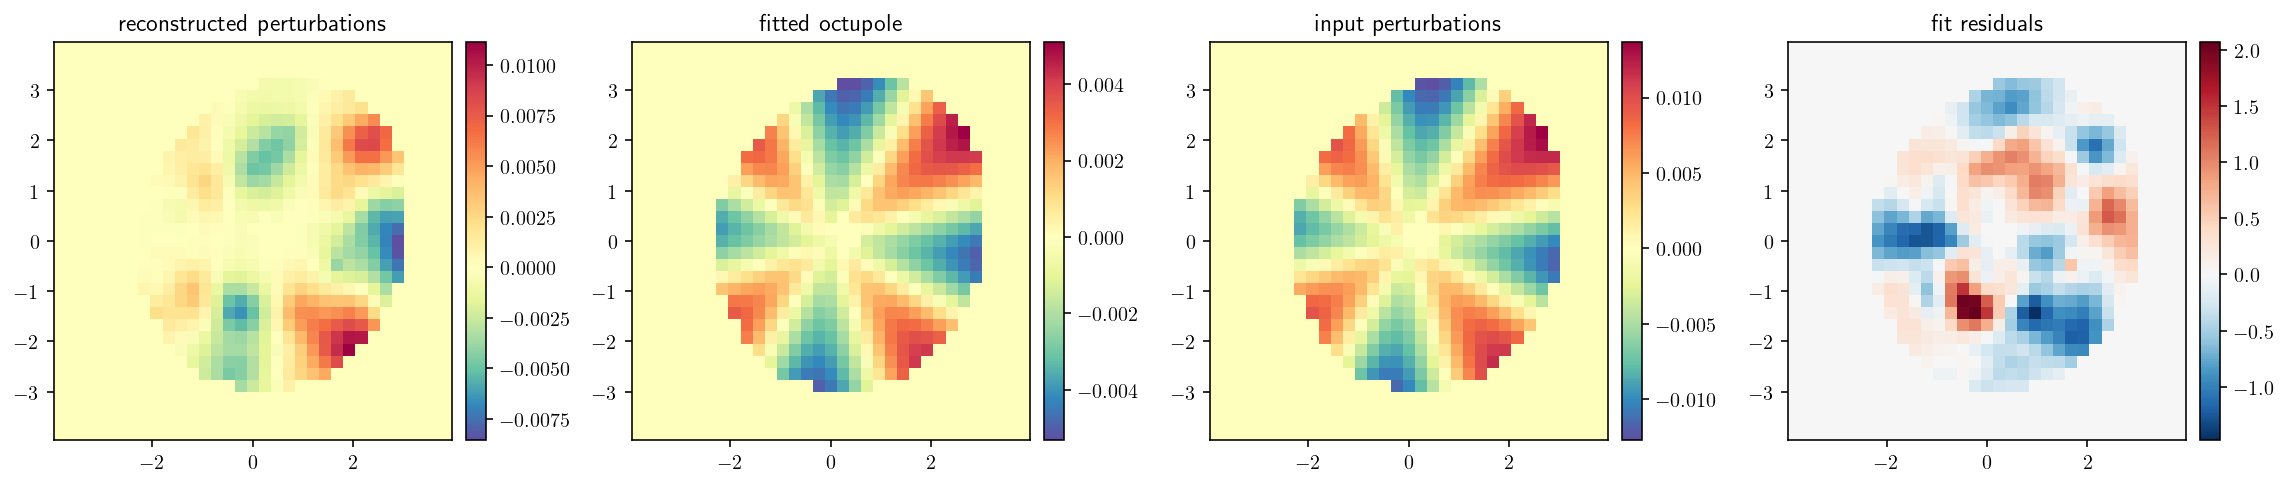

In [38]:
ocupole_input = multipole.function(x_grid_fit, y_grid_fit, 4, **input_kwargs)

offset_model = best_fit[2]
print("offset_model", offset_model)
ocupole_model = multipole.function(x_grid_fit, y_grid_fit, 4, **bf_kwargs) + offset_model


fig, axes = plt.subplots(1, 4, figsize=(16, 4))
ax = axes[0]
ax.set_title("reconstructed perturbations")
im = ax.imshow(model_map * mask_fit, origin='lower', extent=extent,
               cmap='Spectral_r', norm=TwoSlopeNorm(0))
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("fitted octupole")
im = ax.imshow(ocupole_model * mask_fit, origin='lower', extent=extent,
               cmap='Spectral_r', norm=TwoSlopeNorm(0))
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("input perturbations")
im = ax.imshow(ocupole_input * mask_fit, origin='lower', extent=extent,
               cmap='Spectral_r', norm=TwoSlopeNorm(0))
plot_util.nice_colorbar(im)
ax = axes[3]
ax.set_title("fit residuals")
im = ax.imshow((ocupole_model - model_map) / model_error * mask_fit, origin='lower', extent=extent,
               cmap='RdBu_r', norm=TwoSlopeNorm(0))
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

In [50]:
def add_octupule_orientation(ax, phi_4, extent, offset=0, label=None, **plot_kwargs):
    phi = phi_4 + offset
    slope1 = np.sin(phi) / np.cos(phi)
    slope2 = np.sin(phi+np.pi/2) / np.cos(phi+np.pi/2)
    xcoord = np.array([extent[0], extent[1]])
    ax.plot(xcoord, slope1 * xcoord, label=label, **plot_kwargs)
    ax.plot(xcoord, slope2 * xcoord, **plot_kwargs)

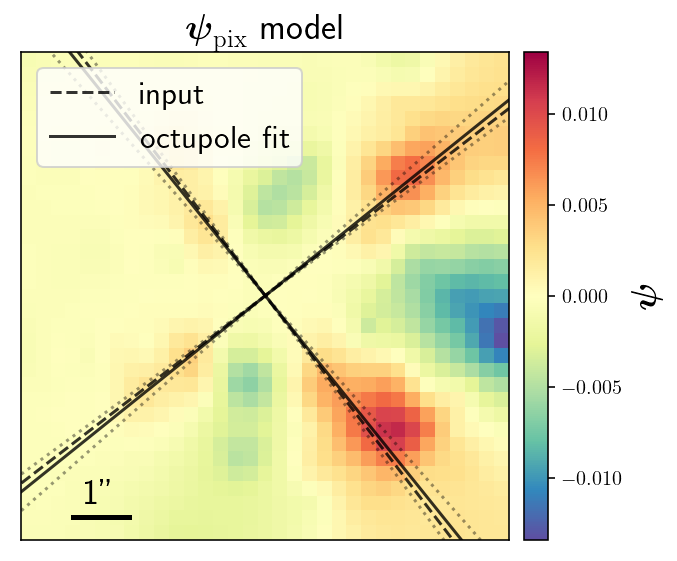

In [55]:
fontsize = 18

# paper figure
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xticks([])
ax.set_yticks([])

ax.set_title(r"$\boldsymbol{\psi}_{\rm pix}$ model", fontsize=fontsize)
pot_mask_nans = np.nan * np.zeros_like(mask_fit)
pot_mask_nans[mask_fit == 0] = 1
vmax = np.abs(model_map).max()
im = ax.imshow(model_map, origin='lower', extent=extent,
               cmap='Spectral_r', vmin=-vmax, vmax=vmax)
im.set_rasterized(True)
#ax.contour(mask, levels=[1], extent=extent, origin='lower', colors='black', 
#           linewidths=2, alpha=0.3, label="fit region")
imm = ax.imshow(pot_mask_nans, extent=extent, origin='lower', cmap='gray_r', alpha=0)
imm.set_rasterized(True)
plot_util.nice_colorbar(im, label=r"$\boldsymbol\psi$", fontsize=18)
add_octupule_orientation(ax, input_kwargs['phi_m'], extent, offset=np.pi/4, 
                         linestyle='--', color='black', alpha=0.8, label="input")
add_octupule_orientation(ax, bf_kwargs['phi_m'], extent, offset=np.pi/4, 
                         linestyle='-', color='black', alpha=0.8, label="octupole fit")
add_octupule_orientation(ax, bf_kwargs['phi_m']+3*bf_uncert['phi_m'], extent, offset=np.pi/4, 
                         linestyle=':', color='black', alpha=0.4)
add_octupule_orientation(ax, bf_kwargs['phi_m']-3*bf_uncert['phi_m'], extent, offset=np.pi/4, 
                         linestyle=':', color='black', alpha=0.4)
add_scale_bar(ax, extent, pix_scl, size_arcsec=1, bar_width_pixel=1, 
              color='black', fontsize=fontsize, position=(extent[0]+10*pix_scl, extent[2]+4*pix_scl))
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.legend(
    #ax.get_legend_handles_labels()[0][::-2],
    #ax.get_legend_handles_labels()[1][::-2],
          loc='upper left',
          #bbox_to_anchor=(-0.05, 0.5), loc='center right', ncol=1,
          fontsize=fontsize-2)
fig.tight_layout()
plt.show()

In [56]:
if SAVE_FIGURES:
    figure_name = 'multipole_orientation.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight', dpi=300)

## Central moment analysis